In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
data = pd.read_csv('Fraud.csv')

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
data.shape

(6362620, 11)

In [7]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
data.duplicated().sum()

0

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [10]:
fraud_counts = data['isFraud'].value_counts()

print(fraud_counts)

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [11]:
data['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [12]:
data.isFraud.nunique()

2

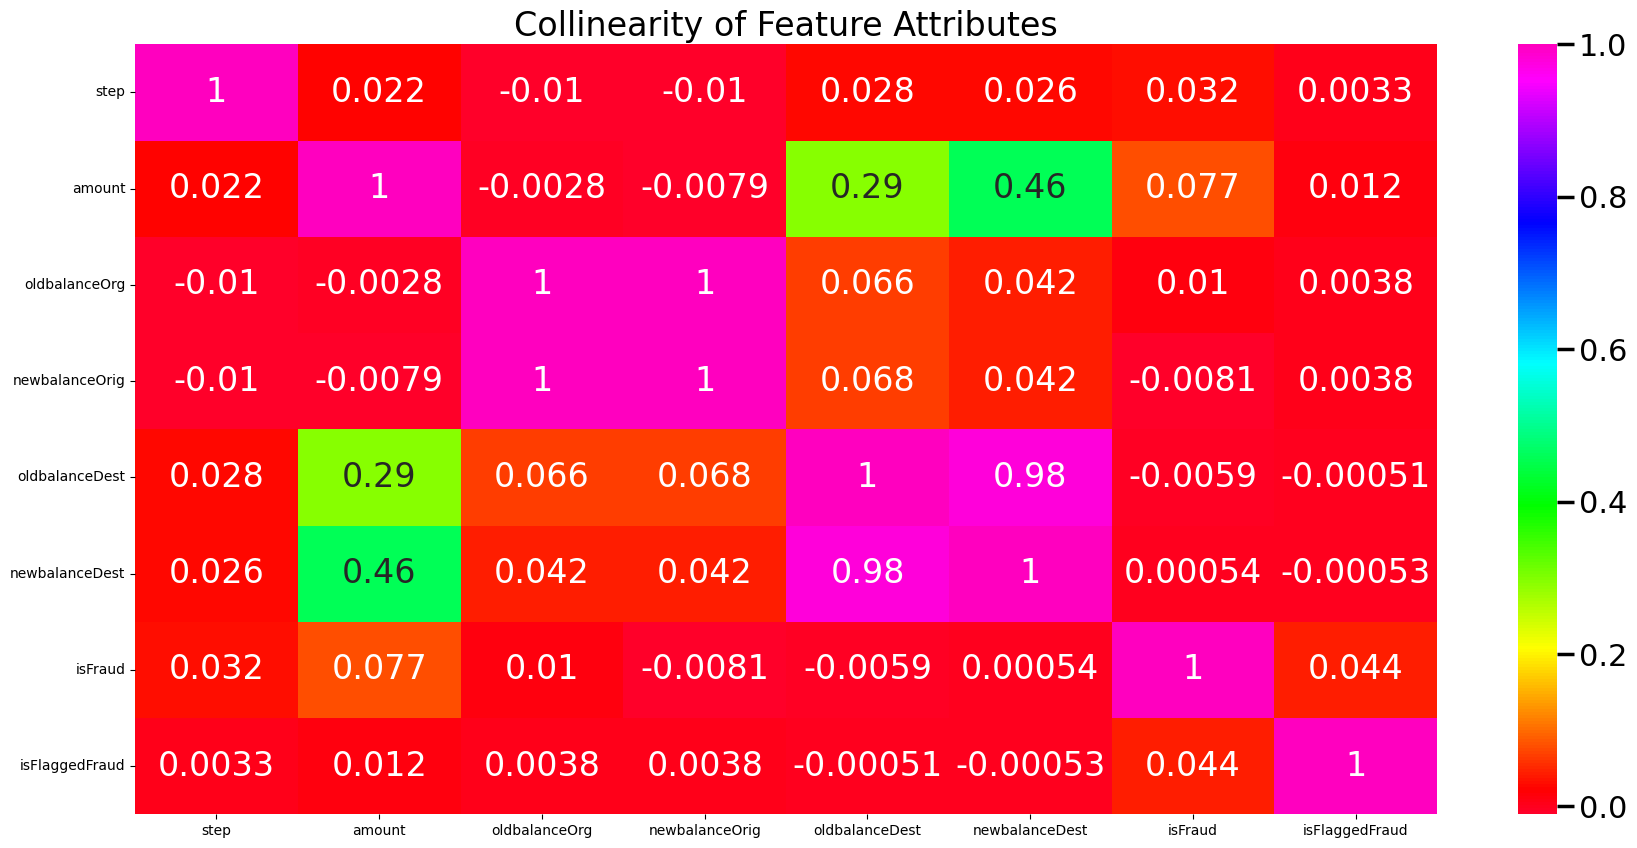

In [13]:
# Hapus atau konversi kolom non-numerik
data_numeric = data.select_dtypes(include=[np.number])

fig, ax = plt.subplots(figsize=(21,10))
sns.set_context('poster')
corr = data_numeric.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,cmap='gist_rainbow', annot = True)
ax.set_title('Collinearity of Feature Attributes')
plt.savefig('cormap.png')


In [14]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [15]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [16]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [17]:
# print percentage of questions where target == 1
percent = (len(data.loc[data.isFraud==1])) / (len(data.loc[data.isFraud == 0])) * 100
print(f"Percentage of Fraudulent Transanctions in the Dataset: {percent}%")

Percentage of Fraudulent Transanctions in the Dataset: 0.129248881917699%


In [18]:
data["type"].nunique()

5

In [19]:
data["type"].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

## Data Drop & Evaluation

**Feature Engineering**

In [20]:
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [21]:
df = data.copy(deep = True)

In [22]:
# get all categorical columns in the dataframe
catCols = [col for col in data.columns if data[col].dtype=="O"]

from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

for item in catCols:
    data[item] = lb_make.fit_transform(data[item])

In [23]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [24]:
# The function below will be used to evaluate different metrics of the algorithms used here.
def evaluate_model(y_test, y_pred):
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Precision Score: ", precision_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred))
    print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))
    

    df = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df1 = pd.DataFrame(df, columns = ['y_Actual','y_Predicted'])

    clf_confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames = ['Predicted'], colnames=['Actual'])

    sns.heatmap(clf_confusion_matrix, annot=True)

In [25]:
X = data.drop('isFraud', axis=1)
y = data.isFraud


# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

Unique predicted labels:  [0]
Accuracy Score:  0.9986904765646856


C:\Users\bayu3\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0
Confusion Matrix:  [[1588572       0]
 [   2083       0]]


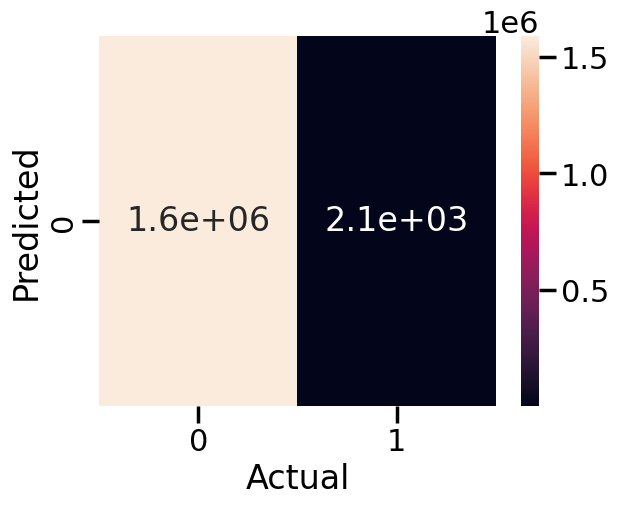

In [26]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

# checking accuracy
evaluate_model(y_test, dummy_pred)

Seperti yang dapat kita lihat, Dummy Classifier secara akurat memprediksi transaksi non-penipuan dengan akurasi 99,8%, tetapi itu bukan fokus kami. Kita harus dapat memprediksi transaksi penipuan secara akurat.

**Logistic Regression**

In [27]:
# Modeling the data as is
# Train model
lr = LogisticRegression()
model1 = lr.fit(X_train, y_train)
 
# Predict on training set
lr_pred = model1.predict(X_test)

C:\Users\bayu3\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score:  0.9990016691237258
Precision Score:  0.6865109269027883
Recall Score:  0.4373499759961594
F1 Score:  0.5343108504398827
Confusion Matrix:  [[1588156     416]
 [   1172     911]]


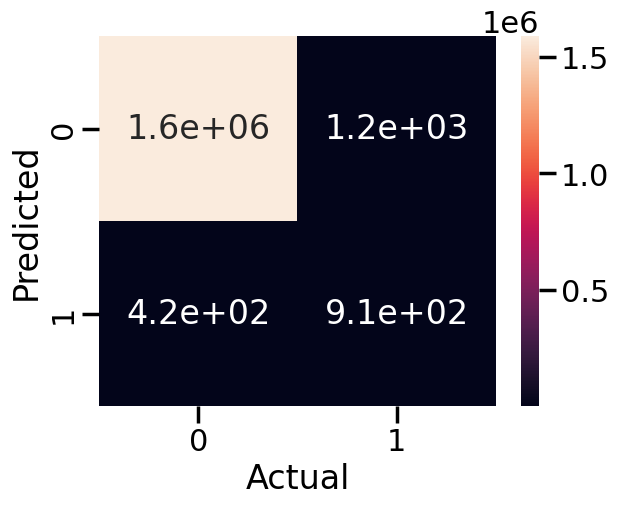

In [28]:
evaluate_model(y_test, lr_pred)

In [29]:
# Checking unique values
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0
0    1589328
1       1327
Name: count, dtype: int64

In [30]:
pd.DataFrame(confusion_matrix(y_test, lr_pred))

,0,1
0,1588156,416
1,1172,911


Model Logistic Regression berkinerja cukup baik tetapi skor recall masih sangat rendah. Lebih banyak pekerjaan yang perlu dilakukan dengan himpunan data.

**Random Forest Classifier**

Accuracy Score:  0.999693208143815
Precision Score:  0.9824561403508771
Recall Score:  0.7796447431589054
F1 Score:  0.8693790149892934
Confusion Matrix:  [[1588543      29]
 [    459    1624]]


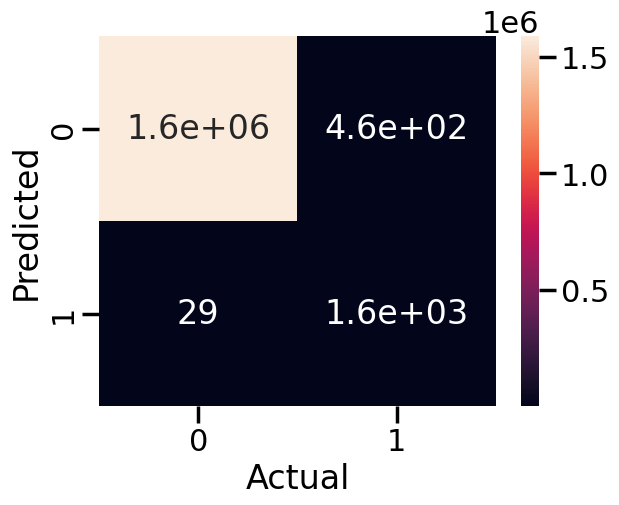

In [31]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

evaluate_model(y_test, rfc_pred)

In [32]:
# Checking unique values
predictions = pd.DataFrame(rfc_pred)
predictions[0].value_counts()

0
0    1589002
1       1653
Name: count, dtype: int64

In [33]:
pd.DataFrame(confusion_matrix(y_test, rfc_pred))

,0,1
0,1588543,29
1,459,1624


Kita dapat melihat bahwa Random Forest memiliki skor terbaik sejauh ini di berbagai metrik dengan skor recall 77% dan skor F1 86%.

In [34]:
import pickle

In [35]:
filename = 'FraudDetect_model.sav'
pickle.dump(rfc, open(filename, 'wb'))

# Selecting Model

Model terakhir yang digunakan yang memiliki skor terbaik di semua metrik adalah Random Forest Classifier.

## Kesimpulan

...